In [35]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=3)  # 3 classes (0, 1, 2)
        
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed


# Paths
TRAIN_DIR = './Train'
TEST_DIR = './Test'
LABELS_FILE = './label_train.csv'

In [36]:
# Load labels
labels_df = pd.read_csv(LABELS_FILE)

# Load training data
def load_data(directory, labels_df):
    X = []
    y = []
    for idx, row in labels_df.iterrows():
        file_name = f"{row['ID']}.npy"
        file_path = os.path.join(directory, file_name)
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    return np.array(X), np.array(y)

X, y = load_data(TRAIN_DIR, labels_df)

print(f"Training data shape: {X.shape}")

Training data shape: (1491, 72, 48)


In [37]:
# Normalize data
X = (X - np.mean(X)) / np.std(X)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Expand dimensions if needed (add channel dimension)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Automatically calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [38]:
# Build the CNN model
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(72, 48, 1)),
        
        # First block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Second block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third block - deeper features
        layers.Conv2D(256, (4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth block - adding more complexity
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        
        # Dense layers for final decision
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),  # Increased dropout to prevent overfitting
        layers.BatchNormalization(),
        
        layers.Dense(64, activation='relu'),
        
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(0.001),
                  loss=focal_loss(gamma=2.0, alpha=0.25),
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 72, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 36, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 36, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 18, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 18, 12, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 9, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 9, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,574,723 (9.82 MB)

 Trainable params: 2,574,467 (9.82 MB)

 Non-trainable params: 256 (1.00 KB)

In [39]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=8,
    validation_data=(X_val, y_val),
    epochs=80,
    class_weight=class_weights_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=25, monitor='val_loss', verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00000001)
    ]
)

Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7323 - loss: 0.0874 - val_accuracy: 0.1706 - val_loss: 0.1370 - learning_rate: 0.0010
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8818 - loss: 0.0371 - val_accuracy: 0.0936 - val_loss: 0.3373 - learning_rate: 0.0010
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8944 - loss: 0.0318 - val_accuracy: 0.1003 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9096 - loss: 0.0249 - val_accuracy: 0.0936 - val_loss: 0.3761 - learning_rate: 0.0010
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9055 - loss: 0.0181 - val_accuracy: 0.3679 - val_loss: 0.1256 - learning_rate: 2.0000e-04
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9178 - loss: 0.0176 - val_accuracy: 0.9532 - val_loss: 0.0063 - learning_rate: 2.0000e-04
Epoch 7/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9407 - 

In [40]:
# Load test data
def load_test_data(directory):
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('.')[0]))
    X_test = []
    file_names = []
    for file in files:
        file_path = os.path.join(directory, file)
        sample = np.load(file_path)
        X_test.append(sample)
        file_names.append(file.split('.')[0])
    return np.array(X_test), file_names

X_test, test_file_names = load_test_data(TEST_DIR)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
X_test = np.expand_dims(X_test, axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
10/10 - 0s - 32ms/step - accuracy: 0.9933 - loss: 0.0018
Validation Accuracy: 0.9933
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


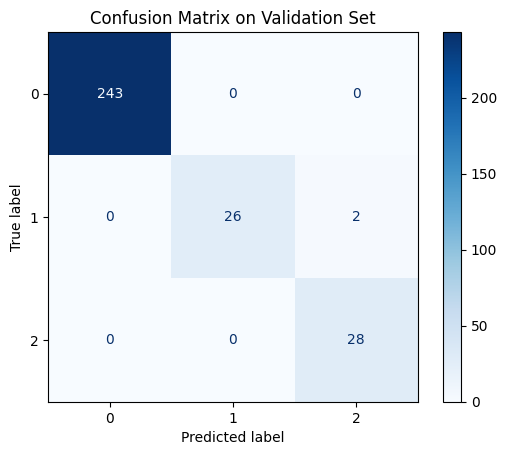

In [41]:
# Predict
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [42]:
# Save for Kaggle
submission = pd.DataFrame({
    'ID': test_file_names,
    'target': predicted_labels
})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
